# Упражнение

Реализовать одну из операций:
1. $e^x$ --- экспонента
2. $\\tanh(x)$ --- гиперболический тангенс

Как метод класса Value. Для тестирования надо построить небольшой вычислительный граф, запустить обратное распространение и отрисовать

In [1]:
from math import exp
from graphviz import Digraph

Так как производная экспоненты равна экспоненте, то градиент предка нужно лишь увеличить на значение экспоненты, умножив на её градиент. Получится функция exp:

In [2]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op


    def exp(self):
        out = Value(exp(self.data), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out


    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out


    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()


    def __neg__(self):
        return self * -1


    def __radd__(self, other):
        return self + other


    def __sub__(self, other):
        return self + (-other)


    def __rsub__(self, other):
        return other + (-self)


    def __rmul__(self, other):
        return self * other


    def __truediv__(self, other):
        return self * other**-1


    def __rtruediv__(self, other):
        return other * self**-1


    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

# Функция для отрисовки графа вычислений

In [32]:
def draw(root, format='svg', rankdir='LR'):
    def trace(root):
        nodes, edges = set(), set()
        def build(v):
            if v not in nodes:
                nodes.add(v)
                for child in v._prev:
                    build(child)
                    edges.add((child, v))
        build(root)
        return edges, nodes
    assert rankdir in ['LR', 'TB']
    edges, nodes = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})

    for n in nodes:
        dot.node(name=f'{id(n)}', label = "{data %.2f | grad %.2f}" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=f'{id(n)}{n._op}', label=n._op)
            dot.edge(f'{id(n)}{n._op}', f'{id(n)}')

    for n1, n2 in edges:
        dot.edge(f'{id(n1)}', f'{id(n2)}{n2._op}')

    return dot

# Примеры

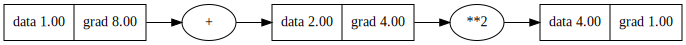

In [36]:
x = Value(1)
res = (x + x) ** 2
res.backward()
draw(res)

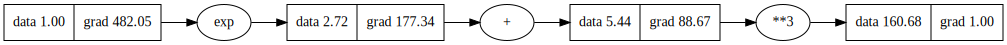

In [37]:
x = Value(1).exp()
res = (x + x) ** 3
res.backward()
draw(res)

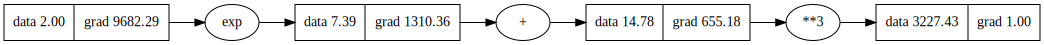

In [38]:
x = Value(2).exp()
res = (x + x) ** 3
res.backward()
draw(res)

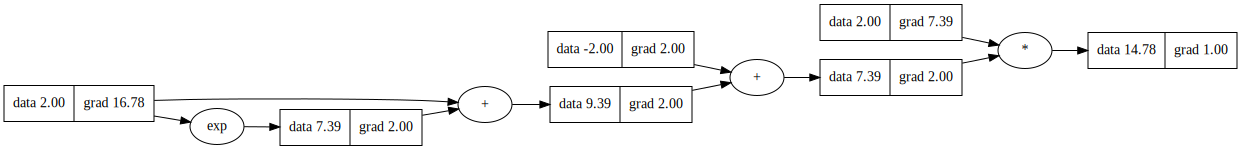

In [22]:
x = Value(2)
res = (x + x.exp() - 2) * 2
res.backward()
draw(res)